# **EDA**

The purpose of this book is to explore the techniques that are used for the main `Drum Tracker` pipeline.

## **Imports**

In [2]:
from IPython.display import Audio
from midiutil import MIDIFile
from models import Model_02
from src import Preprocessor
import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio.transforms as T

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Functions**

In [4]:
def plot_waveform(signal: np.ndarray, rate: int, dashed: bool = True,
                  title: str = 'Signal Waveform'):

    # Show waveform
    librosa.display.waveshow(y=signal, sr=rate, color='blue')

    # Plot dashed lines
    if dashed:
        plt.hlines(
            y = 0, 
            xmin = 0, 
            xmax = signal.shape[0] / rate, 
            colors = 'black',
            linestyles = 'dashed'
        )

    # Plot labels
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.title(title)

    # Show plot
    plt.show()
    

In [5]:
def plot_spectrogram(spec: torch.Tensor, title: str = 'Spectrogram',
                          ax: np.ndarray|None = None):
        """Plots the spectrogram of a signal.

        Parameters
        ----------
        spec : torch.Tensor
            Tensor containing the spectogram of a signal
        title : str, optional
            Title of the file, by default 'Spectrogram'
        ax : np.ndarray | None, optional
            Axes to plot on, by default None
        """

        if ax == None:
            ax = plt.gca()
        ax.imshow(
            librosa.power_to_db(spec),
            origin='lower', 
            aspect='auto',
            interpolation='nearest'
        )
        ax.set_title(title)

## **Data Preview**

Let's examine a sample drum loop to take a closer look.

In [6]:
# Load sample loop
sample, rate = librosa.load('data/loop_01.wav', sr=None)

# Print properties
print(f'Length = {(sample.shape[0] / rate):.2f}s')
print(f'Rate = {rate}Hz.')

Length = 5.83s
Rate = 44100Hz.


In [7]:
# Listen to sample loop
Audio(data=sample, rate=rate)


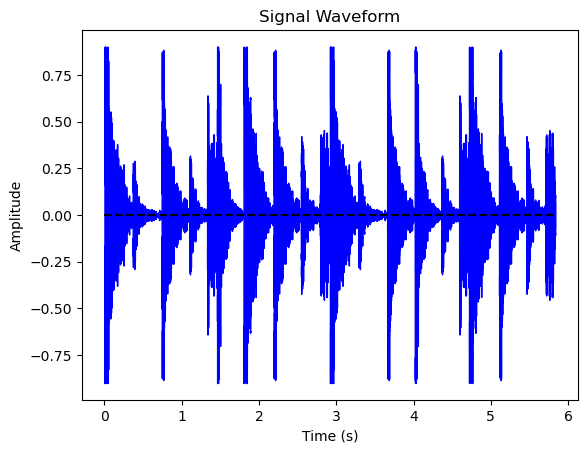

In [8]:
# Plot waveform of the sample loop
plot_waveform(sample, rate)

Drum loops used in hip-hop are typically 4 or 8 bar loops where hi-hat hits every 8th note, the snare every 2nd and 4th beat, and the kick is played sporadically throughout the loop with a definite hit on the 1st beat. What we want to do with this loop is extract a sample of every hit of each instrument and use our model to make a predition of what that instrument is being played in the sample.

The first step is to extract the individual samples out of the loop to feed into our model. In drum loops, identifying each hit of an instrument is made simple by looking at the peaks within the waveform. A common algorithm used in `music information retrieval (MIR)` to detect these peaks is called `Onset Detection`.

## **Detecting Onsets (Peaks) of the Signal**

Fortunately we can use `Librosa` to take care of the backend of the algorithm. There are two methods we will look at, the first is regular onset detection, and the other is onset detection with `backtracking`. Backtracking will help us create clean sample segmentations from the loop by marking the location of an energy minimum before the actual onset. The plot below displays the difference between using backtracking and not.

In [9]:
# Get onset strength envelope of signal to calculate onset frames
oenv = librosa.onset.onset_strength(y=sample, sr=rate, hop_length=1024)

# Get the time values of the envelope given the sampling rate
times = librosa.times_like(oenv, sr=rate)

# Get onset frames without and with backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)

# Add onset marker to beginning of sample
onset_raw = np.insert(onset_raw, 0, 0)
onset_bt = np.insert(onset_bt, 0, 0)


Text(0.5, 1.0, 'Onset Detection with Backtracking')

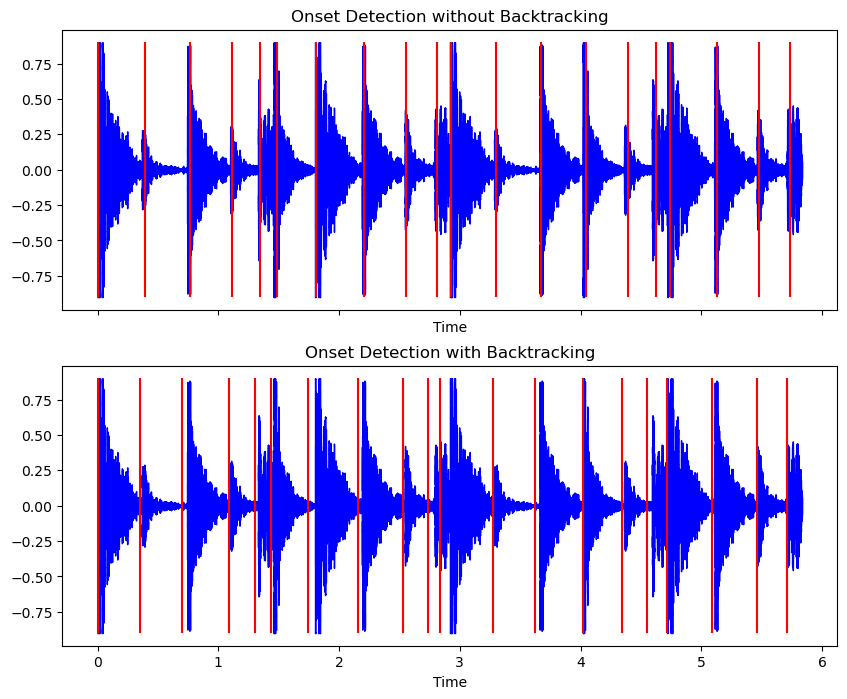

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,8))
librosa.display.waveshow(y=sample, sr=rate, color='blue', ax=ax[0])
librosa.display.waveshow(y=sample, sr=rate, color='blue', ax=ax[1])
ax[0].vlines(librosa.frames_to_time(onset_raw), sample.min(), sample.max(), label='Raw onsets', color='r')
ax[0].set_title('Onset Detection without Backtracking')
ax[1].vlines(librosa.frames_to_time(onset_bt), sample.min(), sample.max(), label='Backtracked', color='r')
ax[1].set_title('Onset Detection with Backtracking')

From above, we see that without backtracking, the onsets are commonly detected _after_ the initial attack of the instrument. This means that a segmented sample would miss information of the current instrument's attack, but also contain the attack of the next instrument. We could also potentially induce a high-pitch noise at the begining or end of the sample by not starting or ending at `zero-cross` or `energy-minimum` point. We'll take the first snare hit as an example, listen to the signals with an without backtracking below and notice how the hit of the next hi-hat is included at the end of the segment.

In [11]:
# Get the locations of the onsets in terms of samples
onset_raw_samples = librosa.frames_to_samples(onset_raw, hop_length=1024)
onset_bt_samples = librosa.frames_to_samples(onset_bt, hop_length=1024)

# Add onset marker to end of sample
onset_raw_samples = np.append(onset_raw_samples, len(sample))
onset_bt_samples = np.append(onset_bt_samples, len(sample))

# Extract the first snare hit using both techniques
snare_raw = sample[onset_raw_samples[2]:onset_raw_samples[3]]
snare_bt = sample[onset_bt_samples[2]:onset_bt_samples[3]]


Sample of the first snare hit without backtracking:

In [12]:
Audio(data=snare_raw, rate=rate)

An _**with**_ backtracking:

In [13]:
Audio(data=snare_bt, rate=rate)

The backtracking from the `Librosa` algorithm isn't perfect, you can likely see from the plots that there are some cases where the onset is a bit early. This wouldn't pose much of a problem if for classification, but it would not be a perfect representation for instrument timing and MIDI extraction. For future improvements, we would want to create a more accurate backtracking algorithm for better timing extraction.

## **MIDI Transcription**

## **Extracting Samples out of the Signal**

Now that we understand onset detection, let's use the onset sample markers to segment the original loop into smaller chops for each instrument hit. We'll store everything in a dictionary containing each `chop`, chop `length`, and the `time` the chop starts in the sample.

In [14]:
# Create dictionary to store samples and information
chop_dict = {
    'chops': [],
    'lengths': [],
    'times': [],
    'labels': [],
    'notes': []
}

# Iterate through onsets in sample
for i in range(len(onset_bt_samples) - 1):
    # Segment chop from sample based on onset sample markers
    chop = sample[onset_bt_samples[i] : onset_bt_samples[i + 1]]

    # Find zero-cross points in chop
    zero_cross = np.nonzero(librosa.zero_crossings(chop))[0]

    # Segment chop to first and last detected zero-cross point
    chop = chop[zero_cross[0]:zero_cross[-1]]

    # Append values to dict
    chop_dict['chops'].append(chop)
    chop_dict['lengths'].append(len(chop) / rate)
    chop_dict['times'].append(onset_bt_samples[i] / rate)

We can take a look at the different chops by playing around with `idx` below.

In [15]:
idx = 1

print(
    f'The chop is {chop_dict['lengths'][idx]:.2f}s long '
    f'and occurs {chop_dict['times'][idx]:.2f}s into the sample.'
)

Audio(data=chop_dict['chops'][idx], rate=rate)

The chop is 0.35s long and occurs 0.35s into the sample.


## **Audio Processing**

Next, we need to apply some signal processing and feature extraction to our chops to make it work with the model. Let's setup each transformation function and explain the reasoning behind it.

### _**1. Downsampling to 16,000Hz**_

The model was trained on data that was downsampled from 44,100Hz to 16,000Hz primarily for saving memory and increasing generalization by using less data points from each sample.

In [16]:
# PyTorch transform function for audio resampling
resample = T.Resample(
    orig_freq = rate, 
    new_freq = 16000
)

### _**2. Converting from Stereo to Mono**_

The reasoning for this is similar to downsampling. Stereo data uses two channels (left and right) and since drum hits are normally similar through both channels, we can convert the signal into one channel and get good results.

In [17]:
# Custom function to downsample from stereo to mono
def stereo_to_mono(waveform: torch.Tensor) -> torch.Tensor:
    if len(waveform.shape) > 1 and waveform.shape[0] > 1:
            return(torch.mean(waveform, dim=0, keepdim=True))
    else:
          return waveform

### _**3. Segmenting the Chops**_

When creating the training data for the model, each drum sample was segmented further into 0.1s chunks to generate more data for training. For example, if a kick drum was 0.65 seconds long and we segmented it into 0.1s chunks, we would have six samples instead of one (discarding the last 0.05s chunk).

Since the model was trained with data like this, we must do the same for predicting our chops. Each chop will be segmented into 0.1s chunks which will be fed into the model for prediction. Taking the average prediction of these chunks will yield the class of the chop.

In [18]:
def segment(waveform: torch.Tensor, chunk_length: int = 160) -> list:
    chunks = torch.split(waveform, chunk_length)
    return chunks

### _**4. Discard Quiet Chunks**_

After segmenting the chops into chunks, we might run into some chunks that have little to no instrument information. These chunks are meaningless and will add noise to the averaged predictions. To remedy this, we can simply discard the quiet chunks by applying a minimum average amplitude threshold. Any chunks that average less than this decible threshold will not be used for prediction.

In [19]:
avg_db_thresh = -80

power_to_db = T.AmplitudeToDB(stype="amplitude", top_db=80)

In [20]:
def get_avg_db(signal: torch.Tensor) -> float:
    """Returns the average decibel level of a signal.

    Parameters
    ----------
    signal : torch.Tensor
        Signal in power amplitude domain.

    Returns
    -------
    float
        Average decibel level of signal.
    """

    if len(signal.shape) == 1:
        signal = signal.unsqueeze(0)

    signal_db = power_to_db(signal)

    return(round(float(torch.mean(signal_db.squeeze(0))), 4))

### _**5.. Mel Spectrogram**_

In [21]:
# Hyperparameters for mel spectrogram transformation
N_FFT = 256
HOP_LEN = N_FFT // 8
N_MELS = 256

# PyTorch transform function for mel spectrogram
mel_spec_trans = T.MelSpectrogram(
    sample_rate = 16000,
    n_fft = N_FFT,
    hop_length = HOP_LEN,
    n_mels = N_MELS
)

/home/vikram/.conda/envs/drum-tracker-cpu/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


## **Using the Classifier Model to Predict Labels**

Now that we've established the audio processing process, the next step is to use the classifier model to make predictions for each chop. First we initialize the model:

In [22]:
# Load model
classifier = Model_02()
# classifier.to(device)
if device == 'cuda':
    classifier.load_state_dict(torch.load('models/model_02.pt'))
else:
    classifier.load_state_dict(torch.load(
        'models/model_02.pt',
        map_location=torch.device('cpu')
))

# Put model into evaluation mode
classifier.eval()

Model_02(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12480, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

Now let's create a function that will be used to get the model's predictions of each chop. Here is what the function will do:

1) Create an empty array `preds` with three columns to append the predictions of each chop's chunks.
2) Convert the chop from a `numpy array` to a `torch tensor`.
3) Use our `segment` function to split the chop into chunks.
4) Loop through the segmented chunks and:
    - Check if the average db is higher than the threshold.
    - Get the logits from the model.
    - Apply the `softmax` function to get the normalized prediction values.
    - Append the results to the `preds` array.
5) Return the `preds` array.

In [23]:
def predict(chop):
    preds = np.empty((0, 3), float)
    chop = torch.tensor(chop)
    chunks = segment(stereo_to_mono(resample(chop)))
    with torch.no_grad():
        for chunk in chunks[:8]:
            if get_avg_db(chunk) > avg_db_thresh:
                logit = classifier(mel_spec_trans(chunk).unsqueeze(0).unsqueeze(0))
                preds = np.append(preds, torch.softmax(logit, dim=1).numpy(), axis=0)
    return preds


We can define a mapping dictionary `class_mapping` that numerically decodes the prediction from integers to actual intrument names.

In [24]:
class_mapping = {
    0 : ['snare', 71],
    1 : ['hat', 70],
    2 : ['kick', 72]
}

Now we can loop through each of the chops and apply our `predict` function to get the instrument label which is appended to `chop_dict`.

In [25]:
for chop in chop_dict['chops']:
    class_map = class_mapping[np.mean(predict(chop), axis=0).argmax()]
    chop_dict['labels'].append(class_map[0])
    chop_dict['notes'].append(class_map[1])

Change the `idx` value below to load different chops and see what the model predicted as its label. You can compare the label to the actual audio to confirm if it works well.

In [26]:
idx = 0

print(
    f'The chop is {chop_dict['lengths'][idx]:.2f}s long, '
    f'occurs {chop_dict['times'][idx]:.2f}s into the sample, '
    f'and is classified as a {chop_dict['labels'][idx]}.'
)

Audio(data=chop_dict['chops'][idx], rate=rate)

The chop is 0.35s long, occurs 0.00s into the sample, and is classified as a kick.


## **MIDI Transcription**

In order to create the midi file, we need an accurate estimation of the tempo of the sample.

In [28]:
bpm = librosa.beat.tempo(
    y = sample,
    sr = rate,
    onset_envelope = oenv,
    start_bpm = 85
)

bpm = int(bpm[0])

print(f'The tempo of the sample is {bpm}bpm.')

The tempo of the sample is 83bpm.


/tmp/ipykernel_10891/3796497588.py:1: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  bpm = librosa.beat.tempo(


In [29]:
track = 0
channel = 0
time = 0
duration = 1
volume = 100

midi = MIDIFile(1)
midi.addTempo(track, time, bpm)

for i, note in enumerate(chop_dict['notes']):
    midi.addNote(track, channel, note, time + i, duration, volume)

with open('test_midi.midi', 'wb') as out_file:
    midi.writeFile(out_file)

## **===============TESTING===============**

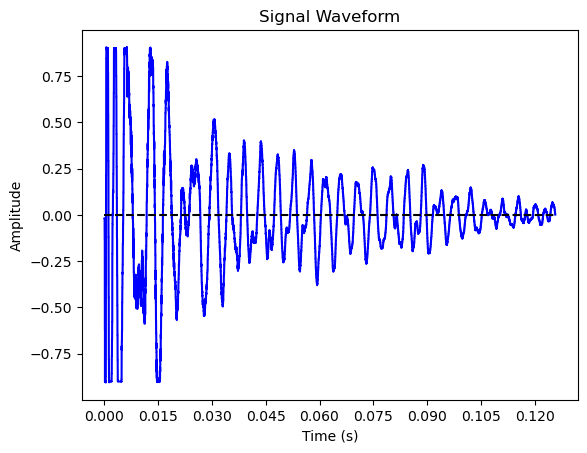

In [31]:
test_chop = resample(chop_tensors[0])

if len(test_chop.shape) > 1 and test_chop.shape[0] > 1:
            test_chop = torch.mean(test_chop, dim=0, keepdim=True)

plot_waveform(test_chop.numpy(), rate)


Break chop into chunks

In [32]:
test_tensor_chunks = torch.split(test_chop.squeeze(0), 160)
test_chunk = test_tensor_chunks[0]
test_chunk.shape

torch.Size([160])

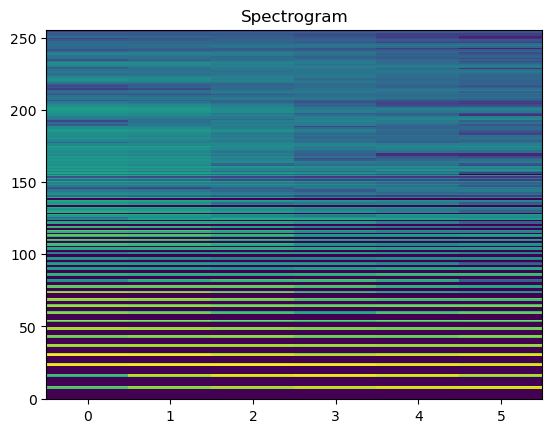

In [33]:
test_chunk = mel_spec_trans(test_chunk.squeeze(0))
plot_spectrogram(test_chunk)

We've now applied processing to each chop from the loop, however there is another processing step we have to take before prediction. Each drum sample was split into 0.1s chunks for the model to train on. Currently our chops are all varying lengths and we will need to create 0.1s chunks of each chop from which we can average out the prediction response of the model fro each chop's chunks.

For example, if we take our first chop and look at its length, we get the following value:

In [40]:
print(f'The length of the first chop is {(len(chop_tensors[0]) / rate):.2f}s.')

The length of the first chop is 0.35s.


We now need to break the chop into 0.1s chunks, discarding the last chunk if it is less than 0.1s.

In [51]:
test_chunk = test_chunk.unsqueeze(0).unsqueeze(0)

In [53]:
with torch.no_grad():
    output = classifier(test_chunk.to(device))
    pred = torch.softmax(output, dim=1).argmax(dim=1)

pred

tensor([2], device='cuda:0')

In [ ]:
classifier

In [43]:
hat, rate = librosa.load('data/hi-hat_001.wav', sr=None)
hat = torch.tensor(hat)
print(hat.shape)
print(rate)

torch.Size([160])
16000


In [46]:
hat_mel = mel_spec_trans(hat).unsqueeze(0).unsqueeze(0)
hat_mel.shape

torch.Size([1, 1, 256, 6])

In [83]:
test = np.empty((0,3), float)
test

array([], shape=(0, 3), dtype=float64)

In [85]:
with torch.no_grad():
    output = classifier(hat_mel)
    pred = torch.softmax(output, dim=1)

# int(pred[0])
test = np.append(test, pred.numpy())
test

array([7.74907938e-04, 9.99225140e-01, 5.04166335e-15, 7.74907938e-04,
       9.99225140e-01, 5.04166335e-15])

In [40]:
from torchsummary import summary
summary(classifier.cuda(), (1, 256, 6))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 258, 8]             320
              ReLU-2           [-1, 32, 258, 8]               0
         MaxPool2d-3           [-1, 32, 129, 4]               0
            Conv2d-4           [-1, 64, 131, 6]          18,496
              ReLU-5           [-1, 64, 131, 6]               0
         MaxPool2d-6            [-1, 64, 65, 3]               0
           Dropout-7            [-1, 64, 65, 3]               0
           Flatten-8                [-1, 12480]               0
            Linear-9                   [-1, 64]         798,784
           Linear-10                    [-1, 3]             195
Total params: 817,795
Trainable params: 817,795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.19
Params size (MB): 3.12
Estimated T